In [ ]:
# installing trranformers library to use distilBert
!pip install transformers

In [ ]:
#importing all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import torch
import torch.nn as nn

import transformers
from torch.optim import AdamW, SGD
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import torch.nn.functional as F

import logging
logging.basicConfig(level=logging.ERROR)


In [ ]:
# loading train data
train = pd.read_csv('/content/PARADE_train.txt', delimiter = "\t")
train = train[['Binary labels', 'Definition1','Definition2']]

# loading test data
test = pd.read_csv('/content/PARADE_test.txt', delimiter = "\t")
test = test[['Binary labels', 'Definition1','Definition2']]


# loading validation data
validation = pd.read_csv('/content/PARADE_validation.txt', delimiter = "\t")
validation = validation[['Binary labels', 'Definition1','Definition2']]

train.head()

,Binary labels,Definition1,Definition2
0,1,predictive models are involved with predicting...,predict a value based on other values in the d...
1,1,predict a value based on other values in the d...,involved with predicting a value based on othe...
2,1,predicting one value (the target variable) usi...,predictive models are involved with predicting...
3,1,predictive models are involved with predicting...,predict value based on other values in data se...
4,0,predict a value based on other values in the d...,predict value based on other values in data se...


#EDA

In [ ]:
# printing the info 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7550 entries, 0 to 7549
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Binary labels  7550 non-null   int64 
 1   Definition1    7550 non-null   object
 2   Definition2    7550 non-null   object
dtypes: int64(1), object(2)
memory usage: 177.1+ KB


In [ ]:
nanRows = train[train.isnull().any(1)]
print(nanRows)

Empty DataFrame
Columns: [Binary labels, Definition1, Definition2]
Index: []


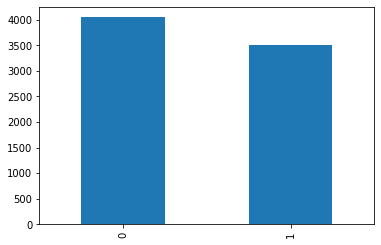

In [ ]:
# fetching the information about how the samples in data are distributed into both classes

trainVis = train.copy(deep = True)

pd.value_counts(trainVis['Binary labels']).plot.bar()

In [ ]:
def count_common_words(row):
    # function to get the number of common words in both the definations
    setWords1 = set(map(lambda word: word.lower().strip(), row['Definition1'].split()))
    setWords2 = set(map(lambda word: word.lower().strip(), row['Definition2'].split()))    
    return 1.0 * len(setWords1 & setWords2)

def common_words_ratio(row):
    # function to get the ratio of common words from both the definations
    setWords1 = set(map(lambda word: word.lower().strip(), row['Definition1'].split(" ")))
    setWords2 = set(map(lambda word: word.lower().strip(), row['Definition2'].split(" ")))    
    return 1.0 * len(setWords1 & setWords2)/(len(setWords1) + len(setWords2))

In [ ]:
# adding new columns to the dataframe for more plot visualization
trainVis['s1len'] = trainVis['Definition1'].str.len() 
trainVis['s2len'] = trainVis['Definition2'].str.len()
trainVis['s1Words'] = trainVis['Definition1'].apply(lambda row: len(row.split()))
trainVis['s2Words'] = trainVis['Definition2'].apply(lambda row: len(row.split()))
trainVis['commonWords'] = trainVis.apply(count_common_words, axis = 1)
trainVis['commonWordsRatio'] = trainVis.apply(common_words_ratio, axis = 1)

trainVis.head()

,Binary labels,Definition1,Definition2,s1len,s2len,s1Words,s2Words,commonWords,commonWordsRatio
0,1,predictive models are involved with predicting...,predict a value based on other values in the d...,168,110,27,19,16.0,0.380952
1,1,predict a value based on other values in the d...,involved with predicting a value based on othe...,110,141,19,24,14.0,0.341463
2,1,predicting one value (the target variable) usi...,predictive models are involved with predicting...,61,92,9,15,4.0,0.166667
3,1,predictive models are involved with predicting...,predict value based on other values in data se...,168,104,27,16,7.0,0.179487
4,0,predict a value based on other values in the d...,predict value based on other values in data se...,110,104,19,16,8.0,0.242424


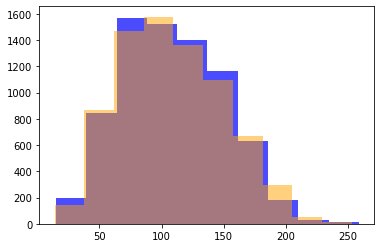

In [ ]:
# visualizing the length of both definitions

plt.hist(trainVis['s1len'], bins=10, alpha=.7, color = 'blue')
plt.hist(trainVis['s2len'], bins=10, alpha=.5, color = 'orange')
plt.show()

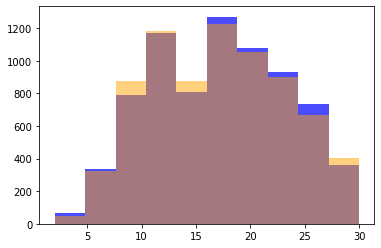

In [ ]:
# visualizing the no. of words in both definitions
plt.hist(trainVis['s1Words'], bins=10, alpha=.7, color = 'blue')
plt.hist(trainVis['s2Words'], bins=10, alpha=.5, color = 'orange')
plt.show()

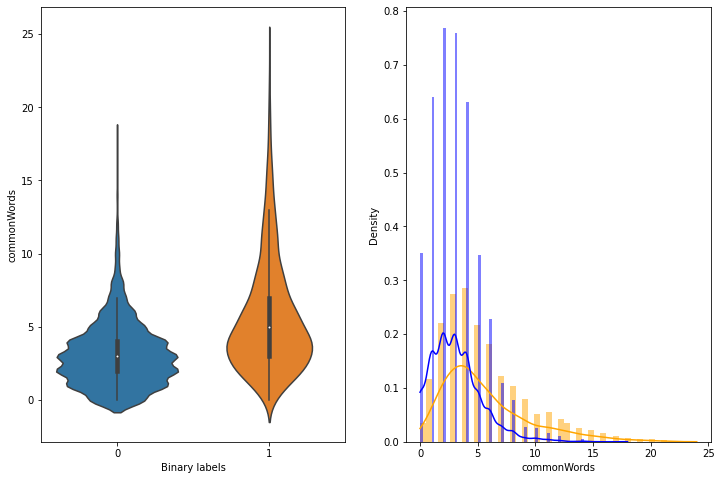

In [ ]:
# Comparison for Common words in both sentences
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = 'Binary labels', y = 'commonWords', data = trainVis[0:])

plt.subplot(1, 2, 2)
sns.histplot(trainVis[trainVis['Binary labels'] == 1.0]['commonWords'][0:] , label = "1", color = 'orange', kde = True, stat="density", linewidth = 0)
sns.histplot(trainVis[trainVis['Binary labels'] == 0.0]['commonWords'][0:] , label = "0" , color = 'blue', kde = True, stat="density", linewidth = 0 )
plt.show()

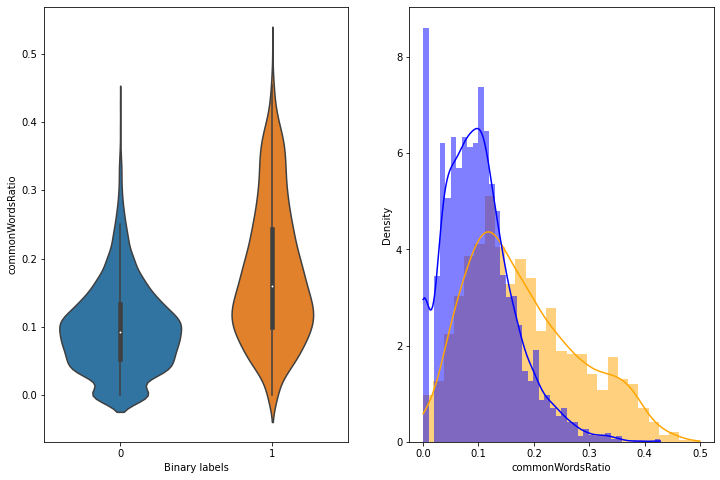

In [ ]:
# Comparison for Common words ratio in both sentences
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = 'Binary labels', y = 'commonWordsRatio', data = trainVis[0:])

plt.subplot(1, 2, 2)
sns.histplot(trainVis[trainVis['Binary labels'] == 1.0]['commonWordsRatio'][0:] , label = "1", color = 'orange', kde=True, stat="density", linewidth=0)
sns.histplot(trainVis[trainVis['Binary labels'] == 0.0]['commonWordsRatio'][0:] , label = "0" , color = 'blue' , kde=True, stat="density", linewidth=0)
plt.show()

The word cloud for definitions that are paraphrased


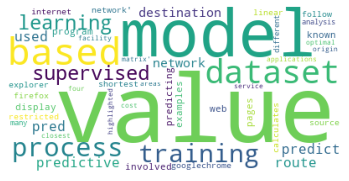


The word cloud for definitions that are not paraphrased


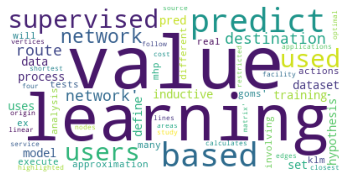

In [ ]:
trainVisParaphrase = trainVis[trainVis['Binary labels'] == 1]
trainVisNotParaphrase = trainVis[trainVis['Binary labels'] == 0]

p = np.dstack([trainVisParaphrase["Definition1"], trainVisParaphrase["Definition2"]]).flatten()
n = np.dstack([trainVisNotParaphrase["Definition1"], trainVisNotParaphrase["Definition2"]]).flatten()

print("The word cloud for definitions that are paraphrased")
wcP = WordCloud(background_color = "white", max_words = len(p), stopwords = STOPWORDS).generate(str(p))
plt.imshow(wcP)
plt.axis("off")
plt.show()


print()
print("The word cloud for definitions that are not paraphrased")
wcN = WordCloud(background_color="white", max_words = len(n), stopwords = STOPWORDS).generate(str(n))
plt.imshow(wcN)
plt.axis("off")
plt.show()


#training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# setting the random seed generator values to particulur constants to control the degree of randomness in the training process
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# setting the hyper parameters for setting up transformer 
VERSION = 'distilbert-base-uncased'
POOLED_OUTPUT_DIM = 768
MAX_LEN = 35
BS = 64

In [ ]:
# defining the dataset class used to set the format of the 
# data that is suitable for the DistilBert's implementation 

class DistilBertDataSet:
    def __init__(self, firstDefinitions, secondDefinitions, targets, tokenizer):
        self.firstDefinitions = firstDefinitions
        self.secondDefinitions = secondDefinitions
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = max(len(secondDefinitions), len(firstDefinitions))
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        firstDefinition = str(self.firstDefinitions[item])
        secondDefinition = str(self.secondDefinitions[item])

        firstDefinition = " ".join(firstDefinition.split())
        secondDefinition = " ".join(secondDefinition.split())
        
        inputs = self.tokenizer.encode_plus(
            firstDefinition,
            secondDefinition,
            add_special_tokens = True,
            padding = 'max_length',
            max_length = 2 * MAX_LEN + 3, 
            truncation = True 
        )
        
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype = torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype = torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype = torch.long) if self.targets is not None else 0
        }
      

In [ ]:
def get_data_loader(df, targets, batch_size, shuffle, tokenizer):
    # helper function to define and return the dataloder used for training the model
    dataset = DistilBertDataSet(
        firstDefinitions = df["Definition1"].values,
        secondDefinitions = df["Definition2"].values,
        targets = targets,
        tokenizer = tokenizer
    )
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle
    )
    
    return data_loader

In [ ]:
# loading pretrained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(VERSION)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# creating data loader for train data
train_data_loader = get_data_loader(
    df = train,
    targets = train["Binary labels"].values,
    batch_size = BS,
    shuffle = True,
    tokenizer = tokenizer
)

# creating data loader for test data
test_data_loader = get_data_loader(
    df = test,
    targets = test["Binary labels"].values,
    batch_size = BS,
    shuffle = True,
    tokenizer = tokenizer
)

# creating data loader for validation data
val_data_loader = get_data_loader(
    df = validation,
    targets = validation["Binary labels"].values,
    batch_size = 4 * BS,
    shuffle = True,
    tokenizer = tokenizer
)



In [ ]:
# Attention class to apply attetion mechanism in our model
class Attention(nn.Module):

    def __init__(self, hidden_size, batch_first=False):
        super(Attention, self).__init__()

        self.hidden_size = hidden_size
        std = 1.0 / np.sqrt(self.hidden_size)

        self.batch_first = batch_first

        self.att_weights = nn.Parameter(torch.Tensor(1, hidden_size), requires_grad=True)

        for weight in self.att_weights:
            nn.init.uniform_(weight, -std, std)


    def forward(self, inputs):
        if self.batch_first:
            batch_size, max_len = inputs.size()[:2]
        else:
            max_len, batch_size = inputs.size()[:2]
            
        weights = torch.bmm(inputs,
                            self.att_weights 
                            .permute(1, 0)  
                            .unsqueeze(0)  
                            .repeat(batch_size, 1, 1) 
                            )
    
        attentions = torch.softmax(F.relu(weights.squeeze()), dim=-1)

        mask = torch.ones(attentions.size(), requires_grad=True).cuda()
        
        masked = attentions * mask
        _sums = masked.sum(-1).unsqueeze(-1)  
        
        attentions = masked.div(_sums)

        weighted = torch.mul(inputs, attentions.unsqueeze(-1).expand_as(inputs))

        representations = weighted.sum(1).squeeze()

        return representations, attentions

In [ ]:
# Final Model Class
class DistilBertModel(nn.Module):
    def __init__(self, distilbertPath,finetune_BERT,freezed_layers):
        super(DistilBertModel, self).__init__()
        self.distilbertPath = distilbertPath
        self.distilbert = transformers.DistilBertModel.from_pretrained(self.distilbertPath)

        # Make DistilBERT layers untrainable/trainable

        if not finetune_BERT:
          for layer in freezed_layers:
              if layer == -1:
                l_name = "embeddings"
              
              else:
                l_name = 'transformer.layer.' + str(layer)

              for name, param in self.distilbert.named_parameters():
                  if l_name in name:
                    param.requires_grad = finetune_BERT
                    
        
        self.lstm1 = nn.LSTM(input_size = 768,
                            hidden_size = 100,
                            num_layers = 1, 
                            bidirectional = True, batch_first = True)
        self.atten1 = Attention(100*2, batch_first = True)
       
        self.lstm2 = nn.LSTM(input_size = 100*2,
                            hidden_size = 100,
                            num_layers = 1, 
                            bidirectional = True, batch_first = True)
        self.atten2 = Attention(100*2, batch_first = True)
         
        self.fc1 = nn.Sequential(nn.Linear(100*2*2, 100*2*2),
                                 nn.BatchNorm1d(100*2*2),
                                 nn.ReLU()) 
        
        self.fc2 = nn.Linear(100*2*2, 1)
        self.dropout = nn.Dropout(0.3)

        
    def forward(self, ids, mask):
        output = self.distilbert(ids, attention_mask = mask)
        x = output[0]
        out1, (h_n, c_n) = self.lstm1(x)
        x, _ = self.atten1(out1)

        out2, (h_n, c_n) = self.lstm2(out1)
        y, _ = self.atten2(out2)
        
        z = torch.cat([x, y], dim = 1)
        z = self.fc1(self.dropout(z))
        z = self.fc2(self.dropout(z))
        
        return torch.sigmoid(z)

In [ ]:
transformers.logging.set_verbosity_error()

In [ ]:
def loss_function(outputs, targets):
    # function to define the loss function
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()((outputs), targets)


def evaluation_metrics(data_loader, model, device, is_train = True):
    # function to return the all the metric values per epoch in list format

    # setting model to evaluation mode
    if not is_train:
        model.eval()

    # list to store outputs and targets
    fin_targets = []
    fin_outputs = []
    
    with torch.no_grad():

        # variable to store the total loss for all data
        total_loss = 0
        
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype = torch.long)
            mask = batch["mask"].to(device, dtype = torch.long)
            targets = batch["targets"].to(device, dtype = torch.float32)

            outputs = model(ids = ids, mask = mask)
            total_loss += loss_function(outputs, targets).item()

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
            

    # converting outputs to final 0, 1 format 
    final_outputs = np.array(fin_outputs) >=0.5

    # calculating the metric scores 
    f1Score = f1_score(fin_targets, final_outputs)
    accuracyScore = accuracy_score(fin_targets, final_outputs)
    recallScore = recall_score(fin_targets, final_outputs)
    precisionScore = precision_score(fin_targets, final_outputs)
    total_loss = total_loss/len(fin_targets)
    
    return f1Score, accuracyScore, recallScore, precisionScore, total_loss


# function for training the network
def train_loop(epochs, train_loader, val_loader, model, optimizer, device, scheduler = None):
    # list to store the training and validation loss and accuracies per epoch
    trainLoss, valLoss = [], []              # loss lists
    trainAccLoss, valAccLoss = [], []        # accuracy lists
    trainPrecision, valPrecision = [], []    # Precision lists
    trainRecall, valRecall = [], []          # Recall lists
    trainF1, valF1 = [], []                  # F1 lists

    f1Score, accuracyS = 0, 0
    
    model.train()

    # loop for running epoch no. of times
    for epoch in range(epochs):
        it = 1
        print('Epoch: ', epoch + 1)
        correct, total = 0, 0

        # running training and validation loss (loss per epoch)
        training_loss, validation_loss = 0,0
        
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype = torch.long)
            mask = batch["mask"].to(device, dtype = torch.long)
            targets = batch["targets"].to(device, dtype = torch.float32)

            outputs = model(ids, mask = mask)

            optimizer.zero_grad()
            
            #calculating the loss
            loss = loss_function(outputs, targets)
            
            # running backprop.
            loss.backward()
            
            optimizer.step()
        
        # calculating the metric score for current epoch based on the trained mode this step
        f1, accuracy, recall, precision, loss = evaluation_metrics(val_data_loader, model, device)
        f1_, accuracy_, recall_, precision_, loss_ = evaluation_metrics(train_data_loader, model, device)

        print('Train Loss:', loss_, end = " ")
        print('| Val F1:', f1,' | Accuracy:', accuracy, '| Recall:', recall,' | Precision:', precision, " | Loss: ", loss)
            
        
        # appending losses per epoch
        trainLoss.append(loss_)
        valLoss.append(loss)
        
        # appending accuracies per epoch
        trainAccLoss.append(accuracy)
        valAccLoss.append(accuracy_)

        # appending precisions per epoch
        trainPrecision.append(precision)
        valPrecision.append(precision_) 

        # appending recall per epoch
        trainRecall.append(recall)
        valRecall.append(recall_)

        # appending f1s per epoch
        trainF1.append(f1)
        valF1.append(f1_) 

    return trainLoss, valLoss, trainAccLoss, valAccLoss, trainPrecision, valPrecision, trainRecall, valRecall, trainF1, valF1

        

def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 3
    
    lr = 3e-5 # Actual lr
    # lr = 1e-1

    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr = lr)
    # optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = num_training_steps
    )
    
    return train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)


In [ ]:
model = DistilBertModel(VERSION, finetune_BERT = Tr, freezed_layers = []).to(device)
trainLoss, valLoss, trainAccLoss, valAccLoss, trainPrecision, valPrecision, trainRecall, valRecall, trainF1, valF1 = run(model, train, device, train_data_loader, val_data_loader)

Epoch:  1
Train Loss: 0.011148475455922006 | Val F1: 0.5185746777862017  | Accuracy: 0.5019607843137255 | Recall: 0.5480769230769231  | Precision: 0.4920863309352518  | Loss:  0.00278750410266951
Epoch:  2
Train Loss: 0.01098263152387758 | Val F1: 0.4751655629139073  | Accuracy: 0.5027450980392156 | Recall: 0.4599358974358974  | Precision: 0.4914383561643836  | Loss:  0.0027829338990005793
Epoch:  3
Train Loss: 0.010952884779860643 | Val F1: 0.4771748492678725  | Accuracy: 0.523921568627451 | Recall: 0.4439102564102564  | Precision: 0.515828677839851  | Loss:  0.0027843482354108027


In [ ]:
evaluation_metrics(test_data_loader, model, device, is_train = False)

(0.3786869647954329,
 0.5187914517317612,
 0.30615384615384617,
 0.49625935162094764,
 0.011228216511410831)

In [ ]:
model

DistilBertModel(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

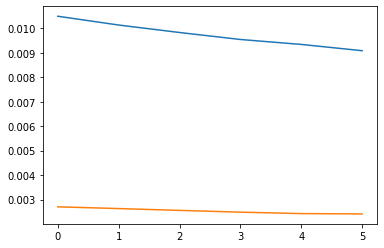

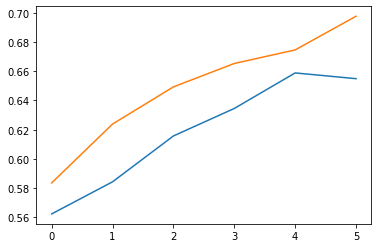

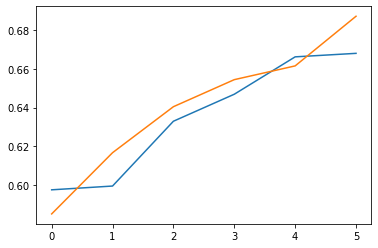

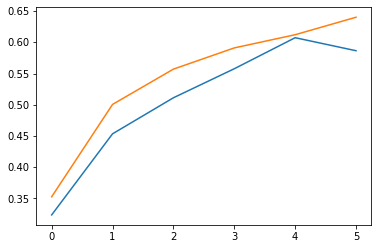

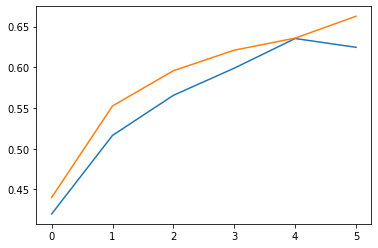

In [ ]:
# Plots.
noOfEpochs = 3
plt.plot(list(range(noOfEpochs)), trainLoss)
plt.plot(list(range(noOfEpochs)), valLoss)
plt.show()


plt.plot(list(range(noOfEpochs)), trainAccLoss)
plt.plot(list(range(noOfEpochs)), valAccLoss)
plt.show()


plt.plot(list(range(noOfEpochs)), trainPrecision)
plt.plot(list(range(noOfEpochs)), valPrecision)
plt.show()


plt.plot(list(range(noOfEpochs)), trainRecall)
plt.plot(list(range(noOfEpochs)), valRecall)
plt.show()

plt.plot(list(range(noOfEpochs)), trainF1)
plt.plot(list(range(noOfEpochs)), valF1)
plt.show()

In [ ]:
PATH = "/content/m3-lstm2-t71.pt"
# torch.save(model.state_dict(), PATH)
model_saved = DistilBertModel(VERSION, finetune_BERT = True, freezed_layers = [-1, 0, 1, 2, 3, 4, 5]).to(device)
model_saved.load_state_dict(torch.load(PATH))
model_saved.eval()

DistilBertModel(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [ ]:
# Misclassified samples.

fin_targets = []
fin_outputs = []
fin_inputs = []
    
with torch.no_grad():
    total_loss = 0
        
    for batch in test_data_loader:
        ids = batch["ids"].to(device, dtype = torch.long)
        mask = batch["mask"].to(device, dtype = torch.long)
        targets = batch["targets"].to(device, dtype = torch.float32)

        for sample in range(ids.shape[0]):
            prediction_as_text = tokenizer.decode(ids[sample], skip_special_tokens=False)
            fin_inputs.append(prediction_as_text)
    

        outputs = model(ids = ids, mask = mask)
        
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
        

final_outputs = np.array(fin_outputs) >=0.5

In [ ]:
count = 0
for i in range(len(final_outputs)):
    if (bool(fin_targets[i]) != final_outputs[i][0]):
        count += 1
        print(fin_inputs[i])
        print(fin_targets[i])

        if (count == 10):
            break

[CLS] the use of it tools and methods to collect, process, consolidate, store, and secure data from sources that are often fragmented and inconsistent [SEP] facilities, processes, and procedures used to collect, store, and distribute information between producers and consumers of information in physical or electronic format [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] source code is compiled into this, and it is then processed by a computer [SEP] a code that is processed by a computer and is copied from a source code [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
evaluation_metrics(test_data_loader, model_saved, device, is_train = False)

(0.7163232963549919,
 0.7361827560795873,
 0.6953846153846154,
 0.738562091503268,
 0.008926547662950037)